### 사용모델:
1. RandomForestRegressor
1. GradientBoostingRegressor
1. Lightgbm
1. KNN

* **이외에 Support Vector Regressor, Ridge, Lasso, XGB regressor 등의 모델 사용 가능하나 여기서는 수업에서 다룬 것들을 바탕으로 진행하였다.**

# [데이터 설명]
* **2017년 4, 5월의 서울 마포구 시간별 기상상황 및 따릉이 대여 수**
* **목표: 1시간 전의 기상 정보를 토대로 따릉이 대여 수 예측하기**
* **데이터 관찰값 1459개를 활용하여 탐색적 데이터 분석, 전처리, 모델링 순으로 진행**
* **SckitLearn의 train_test_split 패키지를 이용하여 cross validation 예측값을 실제값과 비교**
* **출처: 데이콘(https://dacon.io/competitions/open/235576/data)**

# [컬럼 설명]
* **```id```**: 고객 아이디
* **```hour```**: 대여 시간
* **```hour_bef_temperature```**: 1시간 전 기온(섭씨)
* **```hour_bef_precipitation```**: 1시간 전 비 내림 여부. 비가 오지 않았으면 0, 비가 왔으면 1
* **```hour_bef_windspeed```**: 1시간 전 풍속. 단위는 m/s(초속)으로 추정(기상청 https://www.weather.go.kr/weather/climate/average_regional.jsp)
* **```hour_bef_humidity```**: 1시간 전 습도
* **```hour_bef_visibility```**: 1시간 전 시정(視程), 시계(視界)(특정 기상 상태에 따른 가시성을 의미)
* **```hour_bef_ozone```**: 1시간 전 오존
* **```hour_bef_pm10```**: 1시간 전 미세먼지(머리카락 굵기의 1/5에서 1/7 크기의 미세먼지)
* **```hour_bef_pm2.5```**: 1시간 전 미세먼지(머리카락 굵기의 1/20에서 1/30 크기의 미세먼지)
* **```count```**: 자전거 대여량

# [사용할 패키지 로드]
* **사용 언어**: 파이썬

In [1]:
import pandas as pd                  # 데이터분석 패키지
import numpy as np                   # 연산관련 패키지
import matplotlib.pyplot as plt      # 시각화 관련 패키지
import seaborn as sns                # 시각화 관련 패키지
import missingno as msno             # 결측치 시각화 패키지

%matplotlib inline                

import warnings                      # 불필요한 경고메시지 제거 패키지
warnings.filterwarnings('ignore')

# [데이터 로드]
* **1459개의 행 및 10개의 변수로 구성**
    * 독립변수 9개: count를 제외한 나머지
    * 종속변수 1개: count 
* id는 분석에 필요 없으므로 이는 인덱스로만 사용

In [2]:
data = pd.read_csv('train.csv', index_col='id')
print(data.shape)
data.head()

(1459, 10)


,hour,hour_bef_temperature,hour_bef_precipitation,hour_bef_windspeed,hour_bef_humidity,hour_bef_visibility,hour_bef_ozone,hour_bef_pm10,hour_bef_pm2.5,count
id,,,,,,,,,,
3,20,16.3,1.0,1.5,89.0,576.0,0.027,76.0,33.0,49.0
6,13,20.1,0.0,1.4,48.0,916.0,0.042,73.0,40.0,159.0
7,6,13.9,0.0,0.7,79.0,1382.0,0.033,32.0,19.0,26.0
8,23,8.1,0.0,2.7,54.0,946.0,0.040,75.0,64.0,57.0
9,18,29.5,0.0,4.8,7.0,2000.0,0.057,27.0,11.0,431.0


* **분석 편의를 위해 컬럼명의 hour_bef 삭제**

In [3]:
data.columns = ['hour', 'temperature', 'precipitation',
       'windspeed', 'humidity', 'visibility',
       'ozone', 'pm10', 'pm2.5', 'count']
data.columns

Index(['hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'pm2.5', 'count'],
      dtype='object')

# [EDA(탐색적 데이터 분석) 및 전처리]

### 1. 데이터 정보 확인
* **전부 정수(시간) 또는 실수(나머지) 형태로 되어 있음을 알 수 있다.**
* **일부 컬럼에서 결측치가 존재함을 알 수 있다.**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1459 entries, 3 to 2179
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   hour           1459 non-null   int64  
 1   temperature    1457 non-null   float64
 2   precipitation  1457 non-null   float64
 3   windspeed      1450 non-null   float64
 4   humidity       1457 non-null   float64
 5   visibility     1457 non-null   float64
 6   ozone          1383 non-null   float64
 7   pm10           1369 non-null   float64
 8   pm2.5          1342 non-null   float64
 9   count          1459 non-null   float64
dtypes: float64(9), int64(1)
memory usage: 125.4 KB


### 변수 별 요약
**1. 데이터 타입**
* **전부 숫자형태로 되어 있음 --> 연속형 변수**

**2. 결측치(missing value) 여부**
* **기온, 강수여부, 풍속, 습도, 가시성 정보는 1% 미만의 결측치를 가지고 있다.**
* **오존수치, 미세먼지와 관련한 정보는 5 ~ 8% 수준의 결측치를 가지고 있다.**

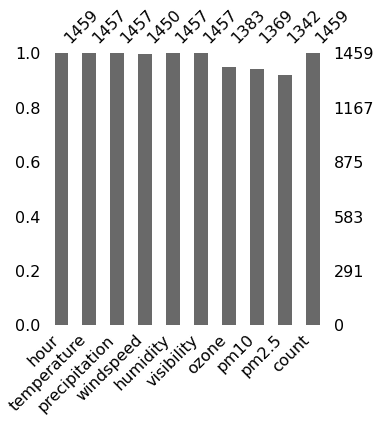

In [5]:
msno.bar(data, figsize = (5, 5))
plt.show()

In [6]:
data_summary = pd.concat([data.dtypes.to_frame(),
                          data.isnull().sum().to_frame(),
                          (data.isnull().sum() / len(data)).to_frame()], axis = 1)

data_summary.columns = ['type','NA(num)', 'NA(ratio)']

data_summary.style.background_gradient(cmap = 'summer_r')

,type,NA(num),NA(ratio)
hour,int64,0,0.000000
temperature,float64,2,0.001371
precipitation,float64,2,0.001371
windspeed,float64,9,0.006169
humidity,float64,2,0.001371
visibility,float64,2,0.001371
ozone,float64,76,0.052090
pm10,float64,90,0.061686
pm2.5,float64,117,0.080192
count,float64,0,0.000000


In [7]:
data_summary.style.bar()

,type,NA(num),NA(ratio)
hour,int64,0,0.000000
temperature,float64,2,0.001371
precipitation,float64,2,0.001371
windspeed,float64,9,0.006169
humidity,float64,2,0.001371
visibility,float64,2,0.001371
ozone,float64,76,0.052090
pm10,float64,90,0.061686
pm2.5,float64,117,0.080192
count,float64,0,0.000000


### 2. hour 컬럼 탐색

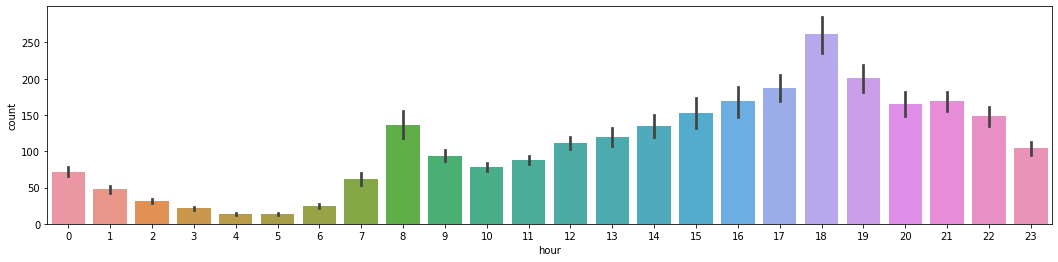

In [8]:
fig, ax = plt.subplots(1, 1, figsize = (18, 4))

sns.barplot(data = data, x = 'hour', y = 'count')
plt.show()

* **시간당 평균 대여량 시각화**
    * 평균 대여량은 18시가 가장 높다.
    * 오전에는 7부터 증가하기 시작하여 8시에 정점을 찍고 대여량이 감소한다. 이를 통해 오전 중에는 출근/등교시간에 이용빈도가 높음을 알 수 있다.
    * 오후에는 11시부터는 서서히 증가하여 18시에 정점을 찍는다. 이를 통해 오전과 마찬가지로 퇴근/하교시간에 이용빈도가 높음을 알 수 있다.
    * 개인의 차이는 있지만, 초/중/고/대학교의 학생들이 활발하게 이용하게 되는 점심시간 이후부터 지속적으로 상승하며,
    * 직장인들의 퇴근과 맞물려 대여량이 큰 폭으로 증가하고 이후는 가족 등과의 여가활동의 대여량으로 이어진다고 추측할 수 있다.

### 3. temperature 컬럼 탐색

In [9]:
data['temperature'].describe()

count    1457.000000
mean       16.717433
std         5.239150
min         3.100000
25%        12.800000
50%        16.600000
75%        20.100000
max        30.000000
Name: temperature, dtype: float64

* **온도 컬럼에는 앞서 언급했듯이 2개의 결측치가 존재한다.**
    * 이는 향후 시간 당 평균 값으로 대체할 것이다.
    
* **최저는 3도, 최고는 30도이며, 평균과 중앙값이 거의 동일하다. 활동하기 좋은 시간대에 대여량이 많이 몰려있는 분포를 보일 것으로 보인다.**

In [10]:
data[data['temperature'].isnull()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
id,,,,,,,,,,
1420,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0
1553,18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


* **결측치가 있는 시간은 각각 0시, 18시 이다.**
* **각 시간 별 평균 온도를 확인한 뒤, 결측치를 채울 것이다.**

In [11]:
data.groupby('hour').mean()['temperature']

hour
0     14.788136
1     14.155738
2     13.747541
3     13.357377
4     13.001639
5     12.673770
6     12.377049
7     12.191803
8     12.600000
9     14.318033
10    16.242623
11    18.019672
12    19.457377
13    20.648333
14    21.234426
15    21.744262
16    22.015000
17    21.603333
18    20.926667
19    19.704918
20    18.191803
21    16.978333
22    16.063934
23    15.418033
Name: temperature, dtype: float64

In [12]:
mean_temp_0 = data[data['hour'] == 0]['temperature'].mean()
mean_temp_18 = data[data['hour'] == 18]['temperature'].mean()

mean_temp_0, mean_temp_18

(14.788135593220337, 20.926666666666666)

In [13]:
data.loc[(data['hour'] == 0) & (data['temperature'].isnull()), 'temperature'] = mean_temp_0
data.loc[(data['hour'] == 18) & (data['temperature'].isnull()), 'temperature'] = mean_temp_18

data[data['temperature'].isnull()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count
id,,,,,,,,,,


**위와 같이 결측치를 시간별 평균으로 대체하고 나니 결측치가 있는 행은 더이상 없는 것을 알 수 있다.**

In [14]:
skew_temp = data['temperature'].skew()
kurt_temp = data['temperature'].kurt()

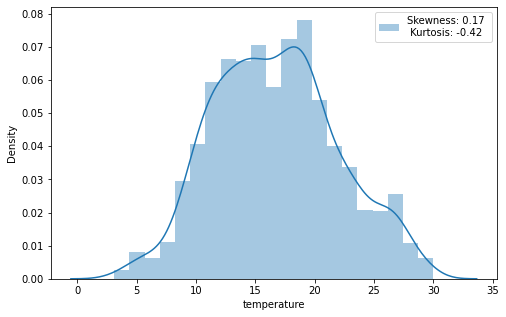

In [15]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
sns.distplot(data['temperature'], 
             label = ('Skewness: {:.2f} \n Kurtosis: {:.2f}'.format(skew_temp, kurt_temp))).legend()
plt.show()

In [16]:
_, bins = np.histogram(data['temperature'], bins = 4)

data['temp_level'] = pd.factorize(pd.cut(data['temperature'], bins = bins, include_lowest = True, labels = np.arange(0,4)))[0]

In [17]:
bins

array([ 3.1  ,  9.825, 16.55 , 23.275, 30.   ])

* **온도구간 1에 해당하는 9.8도 ~ 16.5도 사이의 대여량이 높음을 알 수 있다.**

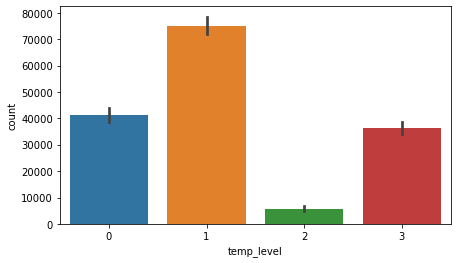

In [18]:
plt.figure(figsize = (7, 4))

sns.barplot(data = data, x = 'temp_level', y = 'count', estimator = np.sum)

plt.show()

### 4. precipitation 컬럼 분석 

* **강수 여부의 경우 2개의 결측치가 존재한다.**
    * 본 컬럼은 범주형 변수의 특성을 가지므로, 평균보다는 해당 시간의 최빈값으로 결측치를 대체하는 것이 좋다고 판단된다.
    
* **강수 여부에 따른 대여량 총계는 피벗테이블을 통해 확인할 수 있다.**
    * 4~5월의 특성 상 비가 오지 않는 날의 대여량이 압도적으로 많음을 알 수 있다.

In [19]:
data[data['precipitation'].isna()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level
id,,,,,,,,,,,
1420,0,14.788136,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.0,0
1553,18,20.926667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1


In [20]:
mode_rain_0 = data[data['hour'] == 0]['precipitation'].mode()
mode_rain_18 = data[data['hour'] == 0]['precipitation'].mode()

mode_rain_0, mode_rain_18

(0    0.0
 dtype: float64,
 0    0.0
 dtype: float64)

In [21]:
data.loc[(data['hour'] == 0) & (data['precipitation'].isnull()), 'precipitation'] = 0
data.loc[(data['hour'] == 18) & (data['precipitation'].isnull()), 'precipitation'] = 0

data[data['precipitation'].isnull()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level
id,,,,,,,,,,,


**위와 같이 결측치를 시간별 최빈값으로 대체하고 나니 결측치가 있는 행은 더이상 없는 것을 알 수 있다.**

In [22]:
pd.pivot_table(data = data, index = 'precipitation', values = 'count', aggfunc = 'count', margins =True)

,count
precipitation,
0.0,1413
1.0,46
All,1459


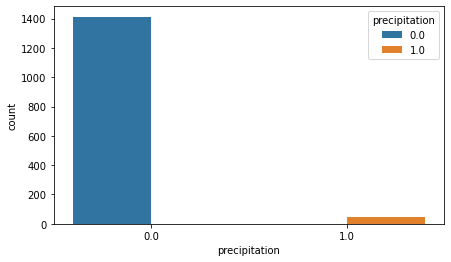

In [23]:
fig, ax = plt.subplots(1, 1, figsize = (7, 4))

sns.countplot(data = data, x = 'precipitation', hue = 'precipitation')
plt.show()

### 5. windspeed 

* **풍속은 9개의 결측치를 갖고 있다.**

In [24]:
data[data['windspeed'].isna()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level
id,,,,,,,,,,,
33,13,22.600000,0.0,NaN,41.0,987.0,0.046,64.0,39.0,208.0,1
381,1,14.100000,0.0,NaN,55.0,1992.0,NaN,NaN,NaN,38.0,0
404,3,14.000000,0.0,NaN,50.0,2000.0,0.049,35.0,22.0,17.0,0
570,0,14.300000,0.0,NaN,49.0,2000.0,0.044,37.0,20.0,58.0,0
1196,20,16.500000,0.0,NaN,31.0,2000.0,0.058,39.0,18.0,181.0,0
1420,0,14.788136,0.0,NaN,NaN,NaN,NaN,NaN,NaN,39.0,0
1553,18,20.926667,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1
1717,12,21.400000,0.0,NaN,44.0,1375.0,0.044,61.0,37.0,116.0,1
1855,2,14.000000,0.0,NaN,52.0,2000.0,0.044,37.0,20.0,20.0,0


* **시간별 평균 풍속을 보면 다음과 같다.**
    * 오전 9시까지 1m/s대, 이후부터 12시까지 2m/s대, 이후부터 20시까지 3m/s이고 다시 2m/s대로 나타난다.
    * 결측치를 채운다면 이 구간의 평균으로 채우는 것이 합당하다고 판단된다.
    * 4, 5월임을 감안하면 풍속 자체가 대여량에 큰 영향을 줄 것으로 보이진 않으나 우선 결측치를 채우고 구간을 나눈 뒤 분포를 살펴봐야 한다.

In [25]:
data.groupby('hour').mean()['windspeed']

hour
0     1.965517
1     1.836667
2     1.633333
3     1.620000
4     1.409836
5     1.296721
6     1.331148
7     1.262295
8     1.632787
9     1.829508
10    2.122951
11    2.485246
12    2.766667
13    3.281356
14    3.522951
15    3.768852
16    3.820000
17    3.801667
18    3.838333
19    3.595082
20    3.278333
21    2.755000
22    2.498361
23    2.195082
Name: windspeed, dtype: float64

In [26]:
mean_wind_1 = data[data['hour'] <= 9]['windspeed'].mean()
mean_wind_2 = data[(data['hour'] > 9) & (data['hour'] <= 12)]['windspeed'].mean()
mean_wind_3 = data[(data['hour'] > 12) & (data['hour'] <= 20)]['windspeed'].mean()
mean_wind_4 = data[data['hour'] > 20]['windspeed'].mean()

mean_wind_1, mean_wind_2, mean_wind_3, mean_wind_4

(1.5793046357615885, 2.4565934065934076, 3.6141078838174274, 2.481318681318683)

In [27]:
data.loc[(data['hour'] <= 9) & (data['windspeed'].isnull()), 'windspeed'] = mean_wind_1
data.loc[((data['hour'] > 9) & (data['hour'] <= 12)) & (data['windspeed'].isnull()), 'windspeed'] = mean_wind_2
data.loc[((data['hour'] > 12) & (data['hour'] <= 20)) & (data['windspeed'].isnull()), 'windspeed'] = mean_wind_3
data.loc[(data['hour'] > 20) & (data['windspeed'].isnull()), 'windspeed'] = mean_wind_4

data[data['windspeed'].isnull()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level
id,,,,,,,,,,,


* **위와 같이 결측치를 시간별 평균으로 대체하고 나니 결측치가 있는 행은 더이상 없는 것을 알 수 있다.**

* **풍속을 0 ~ 2, 2 ~ 3, 3 이상 이렇게 세 구간으로 나눠보겠다.**

In [28]:
data['windspeed'].describe()

count    1459.000000
mean        2.478270
std         1.375978
min         0.000000
25%         1.400000
50%         2.300000
75%         3.400000
max         8.000000
Name: windspeed, dtype: float64

In [29]:
bins = [0, 2, 3, 10]
bins_label = [1, 2, 3]

data['wind_level'] = pd.cut(data['windspeed'], bins = bins, include_lowest = True, labels = bins_label)
data['wind_level']

id
3       1
6       1
7       1
8       2
9       3
       ..
2174    1
2175    3
2176    1
2178    3
2179    3
Name: wind_level, Length: 1459, dtype: category
Categories (3, int64): [1 < 2 < 3]

In [30]:
data['wind_level'].unique()

[1, 2, 3]
Categories (3, int64): [1 < 2 < 3]

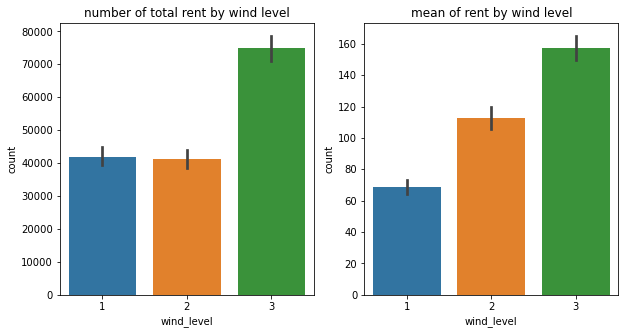

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))

sns.barplot(data = data, x = 'wind_level', y = 'count', estimator = np.sum, ax = ax1)
sns.barplot(data = data, x = 'wind_level', y = 'count', ax = ax2)
ax1.set_title('number of total rent by wind level')
ax2.set_title('mean of rent by wind level')

plt.show()

* **풍속을 구간으로 나누어 보니 풍속이 3 이상일 때 대여량이 높음을 알 수 있다.**

### 6. humidity 컬럼 분석 
* **습도는 강수와 관련이 있으므로 습도의 결측치는 강수 여부에 따른 평균 습도로 채우겠다.**

In [32]:
data[data['humidity'].isnull()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level,wind_level
id,,,,,,,,,,,,
1420,0,14.788136,0.0,1.579305,NaN,NaN,NaN,NaN,NaN,39.0,0,1
1553,18,20.926667,0.0,3.614108,NaN,NaN,NaN,NaN,NaN,1.0,1,3


In [33]:
pd.pivot_table(data, index = 'precipitation', values = 'humidity')

,humidity
precipitation,
0.0,51.214741
1.0,83.413043


In [34]:
data.loc[(data['humidity'].isnull()), 'humidity'] = 51.214741

data[data['humidity'].isna()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level,wind_level
id,,,,,,,,,,,,


In [35]:
skew_hum = data['humidity'].skew()
kurt_hum = data['humidity'].kurt()

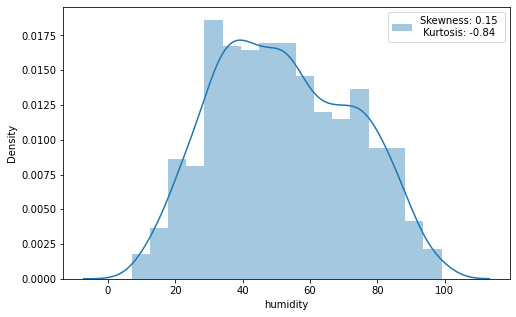

In [36]:
fig, ax = plt.subplots(1, 1, figsize = (8, 5))
sns.distplot(data['humidity'], 
             label = ('Skewness: {:.2f} \n Kurtosis: {:.2f}'.format(skew_hum, kurt_hum))).legend()
plt.show()

In [37]:
_, bins = np.histogram(data['humidity'], bins = 4)

data['hum_level'] = pd.factorize(pd.cut(data['humidity'], bins = bins, include_lowest = True, labels = np.arange(0,4)))[0]

In [38]:
bins

array([ 7., 30., 53., 76., 99.])

* **습도구간 1에 해당하는 30% ~ 53도 사이의 대여량이 높음을 알 수 있다.**

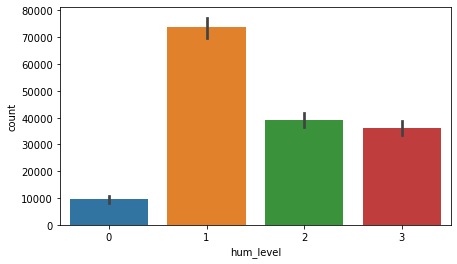

In [39]:
plt.figure(figsize = (7, 4))

sns.barplot(data = data, x = 'hum_level', y = 'count', estimator = np.sum)

plt.show()

### 7. visibility 컬럼 분석 
* **시간당으로 봐도 평균으로 채우는 게 적절할 것으로 생각된다.**

In [40]:
data['visibility'].describe()

count    1457.000000
mean     1405.216884
std       583.131708
min        78.000000
25%       879.000000
50%      1577.000000
75%      1994.000000
max      2000.000000
Name: visibility, dtype: float64

In [41]:
data[data['visibility'].isnull()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level,wind_level,hum_level
id,,,,,,,,,,,,,
1420,0,14.788136,0.0,1.579305,51.214741,NaN,NaN,NaN,NaN,39.0,0,1,1
1553,18,20.926667,0.0,3.614108,51.214741,NaN,NaN,NaN,NaN,1.0,1,3,1


In [42]:
data.loc[(data['visibility'].isna()), 'visibility'] = 1577

### 8. ozone 컬럼 분석 
* **결측치는 평균으로 대체하겠다.**

In [43]:
data[data['ozone'].isna()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level,wind_level,hum_level
id,,,,,,,,,,,,,
28,1,20.0,0.0,1.8,58.0,2000.0,NaN,NaN,NaN,74.0,1,1,2
76,17,21.7,0.0,3.0,35.0,2000.0,NaN,32.0,19.0,213.0,1,2,1
78,1,12.2,0.0,3.0,49.0,1071.0,NaN,NaN,NaN,36.0,0,2,1
130,1,9.4,0.0,2.5,65.0,1907.0,NaN,NaN,NaN,39.0,2,2,2
181,16,26.2,0.0,4.3,31.0,1718.0,NaN,47.0,23.0,136.0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1941,1,16.6,0.0,2.1,35.0,2000.0,NaN,NaN,NaN,62.0,1,2,1
1994,1,15.1,0.0,1.3,35.0,2000.0,NaN,NaN,NaN,40.0,0,1,1
2005,1,17.7,0.0,1.0,43.0,1338.0,NaN,NaN,NaN,69.0,1,1,1


In [44]:
data['ozone'].describe()

count    1383.000000
mean        0.039149
std         0.019509
min         0.003000
25%         0.025500
50%         0.039000
75%         0.052000
max         0.125000
Name: ozone, dtype: float64

In [45]:
data.loc[(data['ozone'].isna()), 'ozone'] = data['ozone'].mean()

### 9. pm10 분석

In [46]:
data[data['pm10'].isna()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level,wind_level,hum_level
id,,,,,,,,,,,,,
28,1,20.0,0.0,1.8,58.0,2000.0,0.039149,NaN,NaN,74.0,1,1,2
78,1,12.2,0.0,3.0,49.0,1071.0,0.039149,NaN,NaN,36.0,0,2,1
130,1,9.4,0.0,2.5,65.0,1907.0,0.039149,NaN,NaN,39.0,2,2,2
149,16,15.8,0.0,5.3,17.0,1923.0,0.047000,NaN,NaN,102.0,0,3,3
193,19,27.0,0.0,3.6,39.0,2000.0,0.047000,NaN,NaN,319.0,3,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005,1,17.7,0.0,1.0,43.0,1338.0,0.039149,NaN,NaN,69.0,1,1,1
2016,19,16.2,0.0,3.5,31.0,950.0,0.060000,NaN,NaN,167.0,0,3,1
2047,1,12.6,0.0,2.4,48.0,1805.0,0.039149,NaN,NaN,43.0,0,2,1


In [47]:
data['pm10'].describe()

count    1369.000000
mean       57.168736
std        31.771019
min         9.000000
25%        36.000000
50%        51.000000
75%        69.000000
max       269.000000
Name: pm10, dtype: float64

In [48]:
data.groupby('hour').mean()['pm10']

hour
0     55.881356
1           NaN
2     58.475410
3     59.180328
4     58.278689
5     56.721311
6     56.150000
7     56.533333
8     57.918033
9     59.147541
10    61.083333
11    60.300000
12    59.344828
13    59.589286
14    58.283333
15    57.355932
16    57.315789
17    57.086207
18    56.875000
19    53.847458
20    53.118644
21    53.933333
22    54.098361
23    54.426230
Name: pm10, dtype: float64

In [49]:
data.loc[(data['pm10'].isna()), 'pm10'] = data['pm10'].mean()

### 10. pm2.5 컬럼 분석 

In [50]:
data[data['pm2.5'].isna()]

,hour,temperature,precipitation,windspeed,humidity,visibility,ozone,pm10,pm2.5,count,temp_level,wind_level,hum_level
id,,,,,,,,,,,,,
28,1,20.0,0.0,1.8,58.0,2000.0,0.039149,57.168736,NaN,74.0,1,1,2
56,21,10.2,0.0,0.5,84.0,1668.0,0.021000,24.000000,NaN,127.0,0,1,0
78,1,12.2,0.0,3.0,49.0,1071.0,0.039149,57.168736,NaN,36.0,0,2,1
130,1,9.4,0.0,2.5,65.0,1907.0,0.039149,57.168736,NaN,39.0,2,2,2
149,16,15.8,0.0,5.3,17.0,1923.0,0.047000,57.168736,NaN,102.0,0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2047,1,12.6,0.0,2.4,48.0,1805.0,0.039149,57.168736,NaN,43.0,0,2,1
2066,11,10.1,0.0,1.5,59.0,990.0,0.015000,39.000000,NaN,78.0,0,1,2
2086,1,11.5,0.0,3.2,23.0,2000.0,0.039149,57.168736,NaN,42.0,0,3,3


In [51]:
data.groupby('hour').mean()['pm2.5']

hour
0     30.982759
1           NaN
2     31.366667
3     31.466667
4     32.116667
5     31.525424
6     31.603448
7     31.779661
8     31.796610
9     31.616667
10    30.948276
11    30.827586
12    29.280702
13    29.946429
14    29.844828
15    28.741379
16    27.910714
17    28.553571
18    29.127273
19    28.338983
20    28.850000
21    29.694915
22    30.216667
23    30.593220
Name: pm2.5, dtype: float64

In [52]:
data['pm2.5'].describe()

count    1342.000000
mean       30.327124
std        14.713252
min         8.000000
25%        20.000000
50%        26.000000
75%        37.000000
max        90.000000
Name: pm2.5, dtype: float64

In [53]:
data.loc[(data['pm2.5'].isna()), 'pm2.5'] = data['pm2.5'].mean()

### 11. 변수들 간 상관관계

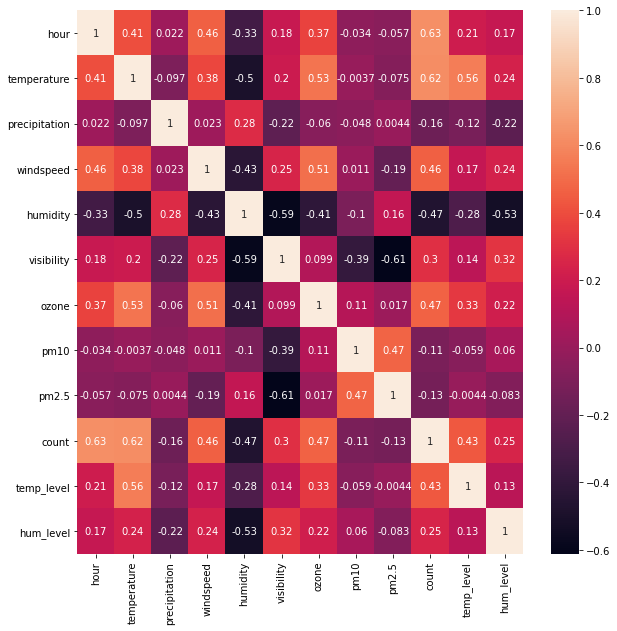

In [54]:
plt.figure(figsize = (10, 10))

sns.heatmap(data.corr(), annot = True)
plt.show()

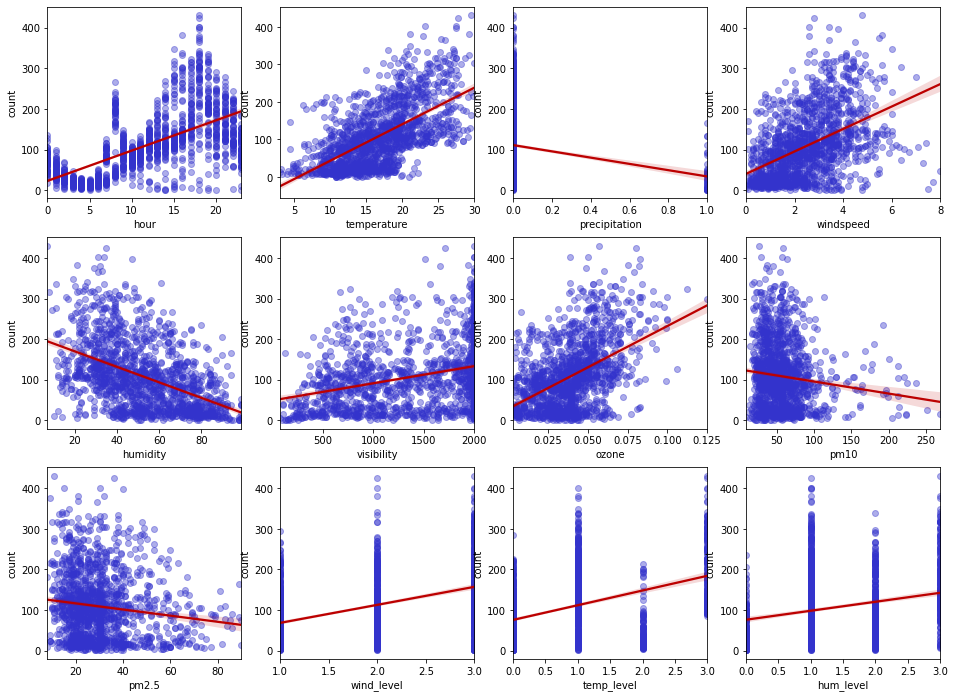

In [55]:
features = ['hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'pm2.5', 'wind_level',
       'temp_level', 'hum_level']

fig, axs = plt.subplots(3, 4, figsize = (16, 12))

for i, feature in enumerate(features):
    row = int(i/4)
    col = i % 4
    sns.regplot(x = feature, y = 'count', data = data, ax = axs[row][col],
               line_kws = {'color':'#bc0000'}, scatter_kws = {'alpha': 0.4,'color' : '#3333cc'})

# [Model 만들기]

In [56]:
data.columns

Index(['hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'pm2.5', 'count', 'temp_level',
       'wind_level', 'hum_level'],
      dtype='object')

In [57]:
features = ['hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10','pm2.5', 'temp_level', 'wind_level', 'hum_level']

In [58]:
label = 'count'

In [59]:
X_train = data[features]
y_train = data[label]

In [60]:
print(X_train.shape)
print(y_train.shape)

(1459, 12)
(1459,)


### 1. Random Forest Regressor 

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [62]:
model_RF = RandomForestRegressor(random_state = 1618)

### 2. Gradient Boosting Regressor

In [63]:
from sklearn.ensemble import GradientBoostingRegressor

In [64]:
model_GBR = GradientBoostingRegressor(random_state = 1618)

### 3. Light Gradient Boosting Machine Regressor : LGBM

In [65]:
import lightgbm as lgb

In [66]:
model_LGB = lgb.LGBMRegressor(seed = 1618)

### 4. K-Nearest Neighbor : KNN

In [67]:
from sklearn.neighbors import KNeighborsRegressor

In [68]:
model_KNN = KNeighborsRegressor()

# [Cross Validation, Fitting, and Prediction]

### 1. Scikit Learn의 train_test_split 패키지 이용

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train,
                                                 test_size = 0.25,
                                                 random_state = 1618)

print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(1094, 12) (365, 12) (1094,) (365,)


In [71]:
model_RF.fit(train_X, train_y)

RandomForestRegressor(random_state=1618)

In [72]:
pred_y_RF = model_RF.predict(val_X)
pred_y_RF[:5]

array([ 80.33,  42.45, 105.39, 130.7 , 185.84])

In [73]:
model_GBR.fit(train_X, train_y)

GradientBoostingRegressor(random_state=1618)

In [74]:
pred_y_GBR = model_GBR.predict(val_X)
pred_y_GBR[:5]

array([ 89.52230915,  41.80463699,  92.82531459, 140.38047941,
       187.10819648])

In [75]:
model_LGB.fit(train_X, train_y)

LGBMRegressor(seed=1618)

In [76]:
pred_y_LGB = model_LGB.predict(val_X)
pred_y_LGB[:5]

array([ 68.00550109,  37.62887477,  82.50617264, 109.3400754 ,
       239.42343557])

In [77]:
model_KNN.fit(train_X, train_y)

KNeighborsRegressor()

In [78]:
pred_y_KNN = model_KNN.predict(val_X)
pred_y_KNN[:5]

array([165.8, 115. ,  56.2, 158.8, 207.6])

# [모델 성능 평가]
## 회귀모델 주요 평가지표 review
1. MAE: Mean Absolute Error(평균절대값잔차). error에 절대값을 취하고 평균한 값
2. MSE: Mean Squared Error(평균제곱잔차. error에 제곱을 하고 평균한 값
3. RMSE: Root Mean Squared Error. MSE에서 제곱으로 인해 에러가 과하게 커지는 것을 방지하기 위해 제곱근을 취한 값
4. RMSLE: Root Mean Sqaured Log Error. RMSE에 로그를 적용, 다음과 같은 특성(장점)을 가진다.
    * outlier에 더욱 robust하고,
    * 로그공식에 의해 예측값과 실제값의 상대적 error를 측정하며,
    * Under estimation에 큰 패널티를 부여한다. 이 패널티를 현실 세계에 대입해 생각해보면, 자전거 대여량의 경우, 대여소의 자전거 수량이 예측 수요 대비 적은 것보다는 조금이라도 더 있는 것이 고객의 입장에서는 수요를 충족할 수 있으니 좋을 것이고 공급자 입장에서는 공급 shortage로 인해 수요를 놓칠 확률을 최대한 낮출 수 있다는 점으로 이해하면 된다.
        
        
4. R-squared: 결정계수. 예측값들의 분산 / 실제값들의 분산. 1에 가까울수록 예측성이 높다. 

### 1. RMSE : Root Mean Squared Error 
* **MAE와의 비교**
1. error를 제곱하고 다 더한 뒤 제곱근을 취함: 큰 오류값에 패널티를 크게 줌
2. 평균을 낼 때 n으로 나누는 것이 아닌 루트n을 사용: 총 결과는 일반적인 평균인 MAE보다 커짐

In [79]:
from sklearn.metrics import mean_squared_error

In [80]:
rmse_RF = np.sqrt(mean_squared_error(val_y, pred_y_RF))

rmse_GBR = np.sqrt(mean_squared_error(val_y, pred_y_GBR))

rmse_LGB = np.sqrt(mean_squared_error(val_y, pred_y_LGB))

rmse_KNN = np.sqrt(mean_squared_error(val_y, pred_y_KNN))

print("RMSE of Random Forest Regressor = {0:.5f}".format(rmse_RF), "\n")
print("RMSE of Gradient Boosting Regressor = {0:.5f}".format(rmse_GBR), '\n')
print("RMSE of LGBM = {0:.5f}".format(rmse_LGB), '\n')
print("RMSE of KNN = {0:.5f}".format(rmse_KNN))

RMSE of Random Forest Regressor = 37.53204 

RMSE of Gradient Boosting Regressor = 38.22326 

RMSE of LGBM = 37.78077 

RMSE of KNN = 65.29046


### 2. RMSLE: Root Mean Sqaured Log Error
* **RMSLE를 적용하기 위해서는 negative value가 없어야 한다.**
    * 수식에 log가 있는데, -log는 정의되지 않기 때문이다.
    * 회귀분석에서는 모델이 어떤 변수의 음의 상관관계에 반응하는 가에 따라 결과값을 negative로 예측할 수도 있다.
    * 본 모델 중 최소값이 negative인 모델은 GBR, LGB 이다.

In [81]:
print(pred_y_RF.min(), pred_y_GBR.min(), pred_y_LGB.min(), pred_y_KNN.min())

7.69 -3.243999145000302 -3.8755832808709374 9.8


* **이 경우, 자전거 대여량은 negative value가 될 수 없으므로 해당 value는 다 0으로 처리해야 한다.**

In [82]:
pred_y_GBR[pred_y_GBR < 0] = 0
pred_y_LGB[pred_y_LGB < 0] = 0

In [83]:
from sklearn.metrics import mean_squared_log_error

In [84]:
rmsle_RF = np.sqrt(mean_squared_log_error(val_y, pred_y_RF))

rmsle_GBR = np.sqrt(mean_squared_log_error(val_y, pred_y_GBR))

rmsle_LGB = np.sqrt(mean_squared_log_error(val_y, pred_y_LGB))

rmsle_KNN = np.sqrt(mean_squared_log_error(val_y, pred_y_KNN))

print("RMSLE of Random Forest Regressor = {0:.5f}".format(rmsle_RF), "\n")
print("RMSLE of Gradient Boosting Regressor = {0:.5f}".format(rmsle_GBR), '\n')
print("RMSLE of LGBM = {0:.5f}".format(rmsle_LGB), '\n')
print("RMSLE of KNN = {0:.5f}".format(rmsle_KNN))

RMSLE of Random Forest Regressor = 0.48543 

RMSLE of Gradient Boosting Regressor = 0.54242 

RMSLE of LGBM = 0.54244 

RMSLE of KNN = 0.83607


### 3.  R-squared
* **분산 기반으로 예측 성능을 평가한다. 실제 값의 분산 대비 예측값의 분산 비율을 지표로 하며, 1에 가까울 수록 예측 정확도가 높다.**

    * R-squared = 예측값 Variance / 실제값 Variance

In [85]:
from sklearn.metrics import r2_score

In [86]:
R2_RF = r2_score(val_y, pred_y_RF)
R2_GBR = r2_score(val_y, pred_y_GBR)
R2_LGBM = r2_score(val_y, pred_y_LGB)
R2_KNN = r2_score(val_y, pred_y_KNN)

print("R2 of RF = {0:.5f}".format(R2_RF), '\n')
print("R2 of GBR = {0:.5f}".format(R2_GBR), '\n')
print("R2 of LGBM = {0:.5f}".format(R2_LGBM), '\n')
print("R2 of KNN = {0:.5f}".format(R2_KNN))

R2 of RF = 0.77664 

R2 of GBR = 0.76840 

R2 of LGBM = 0.77376 

R2 of KNN = 0.32406


### 4. 산점도를 통한 예측값과 실제값 시각화 비교

#### 먼저, 성능이 가장 우수한 Light Gradient Boosting Model을 살펴보면 다음과 같다. 

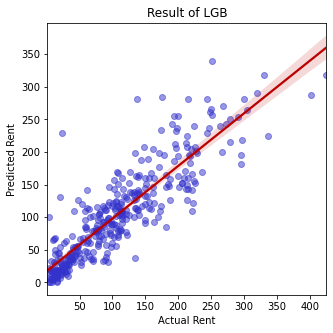

In [87]:
fig, axes = plt.subplots(1,1,figsize=(5,5))
sns.regplot(val_y, pred_y_LGB, line_kws = {'color':'#bc0000'}, scatter_kws = {'alpha': 0.5,'color' : '#3333cc'})

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Result of LGB')

plt.show()

#### 가장 열등한 KNN을 살펴보면 다음과 같다.

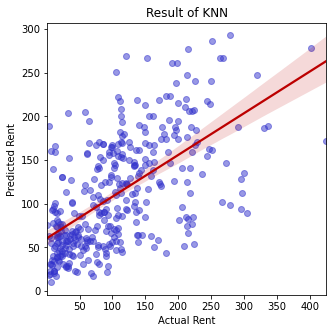

In [88]:
fig, axes = plt.subplots(1,1,figsize=(5,5))
sns.regplot(val_y, pred_y_KNN, line_kws = {'color':'#bc0000'}, scatter_kws = {'alpha': 0.5,'color' : '#3333cc'})

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Result of KNN')

plt.show()

# [모델별  개선 진행]

## 1. Grid search를 통한 Hyperparameter tuning 

In [103]:
from sklearn.model_selection import GridSearchCV

### 1) RandomForest의 최적 Hyper parameter 탐색

In [ ]:
RF_param_grid = {'n_estimators':[200, 300, 400, 500],
                'max_depth' : [4, 6, 8, 10, 12, 15],
                 'min_samples_split' : [1, 2, 3, 4]
                }

In [ ]:
RF_grid = GridSearchCV(model_RF, param_grid = RF_param_grid, scoring = 'r2',
                      n_jobs = -1, verbose = 1)

RF_grid.fit(X_train, y_train)

In [ ]:
print(RF_grid.best_score_,'\n',RF_grid.best_params_)

**기존 점수인 0.75347에서 0.77827로 개선되었음을 확인**

### 2) Gradient Boosting의 최적 Hyper parameter 탐색

In [ ]:
GBR_param_grid = {'n_estimators':[200, 300, 400, 500],
                'max_depth' : [4, 6, 8, 10, 12, 15],
                'learning_rate' : [0.01, 0.05, 0.1],
                'min_samples_split' : [1, 2, 3, 4]
                }

In [ ]:
GBR_grid = GridSearchCV(model_GBR, param_grid = GBR_param_grid, scoring = 'r2',
                      n_jobs = -1, verbose = 1)

GBR_grid.fit(X_train, y_train)

In [ ]:
print(GBR_grid.best_score_,'\n',GBR_grid.best_params_)

**기존 점수인 0.75951에서 0.78078로 개선되었음을 확인**

### 3) LGBM의 최적 Hyper parameter 탐색

In [ ]:
LGB_param_grid = {'n_estimators':[100, 200, 300, 400, 500],
                'max_depth' : [10, 12, 15, 20, 30],
                'min_child_samples':[5, 10, 15, 20, 40, 60],
                'sub_sample' : [0.2, 0.5, 0.8, 1],
                'learning_rate' : [0.001, 0.01, 0.05, 0.1]
                }


In [ ]:
LGB_grid = GridSearchCV(model_LGB, param_grid = LGB_param_grid, scoring = 'r2',
                      n_jobs = -1, verbose = 1)

LGB_grid.fit(train_X, train_y)

In [ ]:
print(LGB_grid.best_score_,'\n',LGB_grid.best_params_)

**기존 점수인 0.76975에서 0.79651로 크게 개선되었음을 확인**

## 2. KNN의 전처리 추가 및 최적 k 탐색

### 1)  정규화(Normalization)
* **KNN은 거리를 기준으로 학습하기 때문에, 개별 변수들의 편차가 각양각색이면 모든 특성들을 고르게 반영하지 못한다.**
* **이 경우 아래의 두 방법으로 feature들의 값들을 정규화할 수 있다.**

    1) min-max scale: 최소값을 0, 최대값을 1로 고정하여 모든 값들을 0과 1사이로 변환
    
    2) 평균과 표준편차를 활용하여 평균으로부터 얼마나 떨어져 있는지를 z-score로 변환
    * 실무에서는 대개 2)의 방법을 사용

In [95]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

* **아래와 같이 정규화를 위한 평균과 표준편차를 계산하는 fitting을 수행한다.**

In [96]:
scaler.fit(train_X)

StandardScaler()

* **아래와 같이 사용할 feature들의 특성을 전부 정규화한다.**
    * 여기서는 교차검증에서 분리했던 train_X, val_X를 이용한다.

In [97]:
train_X_scale = scaler.transform(train_X)
val_X_scale = scaler.transform(val_X)

### 2) 최적의 K 탐색

In [98]:
from sklearn.model_selection import cross_val_score

In [99]:
k_range = range(1, 100)
k_score = []

for k in k_range:
    model_tuning_knn = KNeighborsRegressor(k)
    scores = cross_val_score(model_tuning_knn, train_X_scale, train_y, cv = 10, scoring = 'r2')
    k_score.append(scores.mean())

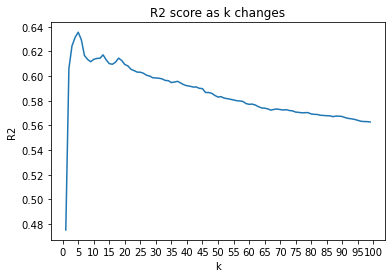

In [100]:
fig, ax = plt.subplots(1, 1, figsize = (6,4))
plt.plot(k_range, k_score)
plt.xlabel('k')
plt.ylabel('R2')
plt.title('R2 score as k changes')
plt.xticks(np.arange(0, 101, step = 5))

plt.show()

* **정규화를 통해 R2스코어가 기존의 0.36576 대비 두 배 가까이 증가한 것을 알 수 있다.**
* **최적의 k를 정확히 탐색하기 위해 아래와 같이 Grid Search를 수행한다.**

In [101]:
KNN_param_grid = {'n_neighbors':[2, 3, 4, 5, 6, 7],
                'weights' : ['uniform', 'distance'],
                  'p' : [1, 2],
                  'metric' : ['minkowski', 'euclidean', 'mahalanobis']                  
                }

In [104]:
KNN_grid = GridSearchCV(model_KNN, param_grid = KNN_param_grid, scoring = 'r2',
                      n_jobs = -1, verbose = 1)

KNN_grid.fit(train_X_scale, train_y)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:    3.1s finished


GridSearchCV(estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['minkowski', 'euclidean', 'mahalanobis'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='r2', verbose=1)

In [105]:
print(KNN_grid.best_score_,'\n',KNN_grid.best_params_)

0.6670183302942457 
 {'metric': 'minkowski', 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}


**기존 점수인 0.36576에서 0.66670으로 굉장히 크게 개선되었음을 확인**

# [개선사항을 반영하여 재 모델링]

In [106]:
model_RF_new = RandomForestRegressor(n_estimators=500, max_depth = 15, min_samples_split = 3, random_state = 1618)

# loss = huber --> to make our model robust to outliers.
model_GBR_new = GradientBoostingRegressor(n_estimators = 200, learning_rate = 0.1, max_depth = 6, 
                                      loss = 'huber', min_samples_split = 4, random_state = 1618)

model_LGB_new = lgb.LGBMRegressor(objective = 'regression', n_estimators = 300, learning_rate = 0.05,
                             max_depth = 20, min_child_samples = 5, num_leaves = 20, subsample = 0.2, seed = 1618)

model_KNN_new = KNeighborsRegressor(n_neighbors= 4, p = 1, weights = 'distance', metric = 'minkowski')

# [Cross Validation, Fitting, and Prediction]

In [107]:
model_RF_new.fit(train_X, train_y)

pred_y_RF_new = model_RF_new.predict(val_X)
pred_y_RF_new[:5]

array([ 79.71444362,  42.24071082, 106.33405238, 129.00597991,
       197.336779  ])

In [108]:
model_GBR_new.fit(train_X, train_y)

pred_y_GBR_new = model_GBR_new.predict(val_X)
pred_y_GBR_new[:5]

array([ 81.08476102,  43.40322766, 112.30712947, 128.44238195,
       217.68263839])

In [109]:
# lgbm의 빠른 속도를 위해 early_stopping_rounds 추가
evals = [(val_X, val_y)]

model_LGB_new.fit(train_X, train_y, early_stopping_rounds = 100, eval_set = evals, verbose = False)

pred_y_LGB_new = model_LGB_new.predict(val_X)
pred_y_LGB_new[:5]

array([ 77.42218592,  41.69874484,  90.75196445, 150.52047443,
       236.18546512])

In [110]:
# KNN은 정규화한 feature를 이용하여 fitting

model_KNN_new.fit(train_X_scale, train_y)

pred_y_KNN_new = model_KNN_new.predict(val_X_scale)
pred_y_KNN_new[:5]

array([ 75.39977999,  38.12417185, 108.10273296, 113.78897603,
       270.61431676])

# [개선된 모델의 성능 평가] 

### 1. RMSE : Root Mean Squared Error 

In [111]:
from sklearn.metrics import mean_squared_error

In [112]:
rmse_RF_new = np.sqrt(mean_squared_error(val_y, pred_y_RF_new))

rmse_GBR_new = np.sqrt(mean_squared_error(val_y, pred_y_GBR_new))

rmse_LGB_new = np.sqrt(mean_squared_error(val_y, pred_y_LGB_new))

rmse_KNN_new = np.sqrt(mean_squared_error(val_y, pred_y_KNN_new))

print("New RMSE of Random Forest Regressor = {0:.5f}".format(rmse_RF_new), "\n")
print("New RMSE of Gradient Boosting Regressor = {0:.5f}".format(rmse_GBR_new), '\n')
print("New RMSE of LGBM = {0:.5f}".format(rmse_LGB_new), '\n')
print("New RMSE of KNN = {0:.5f}".format(rmse_KNN_new))

New RMSE of Random Forest Regressor = 37.13948 

New RMSE of Gradient Boosting Regressor = 37.15331 

New RMSE of LGBM = 36.72878 

New RMSE of KNN = 45.54629


### 2. RMSLE: Root Mean Sqaured Log Error

In [113]:
print(pred_y_RF_new.min(), pred_y_GBR_new.min(), pred_y_LGB_new.min(), pred_y_KNN_new.min())

7.819689538239536 -2.049080649477523 -3.1805955895410714 10.940467553664242


* **자전거 대여량은 negative value가 될 수 없으므로 해당 value는 다 0으로 처리해야 한다.**

In [114]:
pred_y_GBR_new[pred_y_GBR_new < 0] = 0
pred_y_LGB_new[pred_y_LGB_new < 0] = 0

In [115]:
from sklearn.metrics import mean_squared_log_error

In [116]:
rmsle_RF_new = np.sqrt(mean_squared_log_error(val_y, pred_y_RF_new))

rmsle_GBR_new = np.sqrt(mean_squared_log_error(val_y, pred_y_GBR_new))

rmsle_LGB_new = np.sqrt(mean_squared_log_error(val_y, pred_y_LGB_new))

rmsle_KNN_new = np.sqrt(mean_squared_log_error(val_y, pred_y_KNN_new))

print("New RMSLE of Random Forest Regressor = {0:.5f}".format(rmsle_RF_new), "\n")
print("New RMSLE of Gradient Boosting Regressor = {0:.5f}".format(rmsle_GBR_new), '\n')
print("New RMSLE of LGBM = {0:.5f}".format(rmsle_LGB_new), '\n')
print("New RMSLE of KNN = {0:.5f}".format(rmsle_KNN_new))

New RMSLE of Random Forest Regressor = 0.48965 

New RMSLE of Gradient Boosting Regressor = 0.50719 

New RMSLE of LGBM = 0.49812 

New RMSLE of KNN = 0.61337


### 3.  R-squared

In [117]:
from sklearn.metrics import r2_score

In [118]:
R2_RF_new = r2_score(val_y, pred_y_RF_new)
R2_GBR_new = r2_score(val_y, pred_y_GBR_new)
R2_LGBM_new = r2_score(val_y, pred_y_LGB_new)
R2_KNN_new = r2_score(val_y, pred_y_KNN_new)

print("New R2 of RF = {0:.5f}".format(R2_RF_new), '\n')
print("New R2 of GBR = {0:.5f}".format(R2_GBR_new), '\n')
print("New R2 of LGBM = {0:.5f}".format(R2_LGBM_new), '\n')
print("New R2 of KNN = {0:.5f}".format(R2_KNN_new))

New R2 of RF = 0.78128 

New R2 of GBR = 0.78114 

New R2 of LGBM = 0.78613 

New R2 of KNN = 0.67106


### 4. 산점도를 통한 예측값과 실제값 시각화 비교

#### 먼저, 성능이 가장 우수한 Light Gradient Boosting Model을 살펴보면 다음과 같다. 

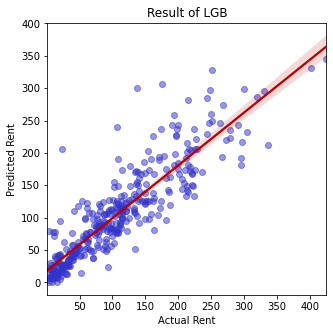

In [119]:
fig, axes = plt.subplots(1,1,figsize=(5,5))
sns.regplot(val_y, pred_y_LGB_new, line_kws = {'color':'#bc0000'}, scatter_kws = {'alpha': 0.5,'color' : '#3333cc'})

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Result of LGB')

plt.show()

* **KNN의 예측값의 흩어짐 정도가 기존보다 대폭 개선된 점을 확인할 수 있다.**

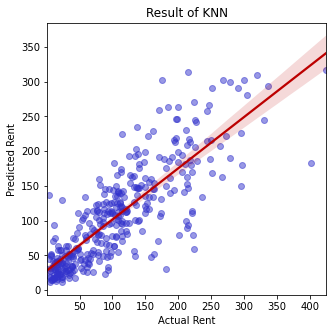

In [120]:
fig, axes = plt.subplots(1,1,figsize=(5,5))
sns.regplot(val_y, pred_y_KNN_new, line_kws = {'color':'#bc0000'}, scatter_kws = {'alpha': 0.5,'color' : '#3333cc'})

plt.xlabel('Actual Rent')
plt.ylabel('Predicted Rent')
plt.title('Result of KNN')

plt.show()

# [모델별  feature importance 확인]

### 1. LGBM regressor

In [121]:
feature_importance_LGB = model_LGB_new.feature_importances_
Series_feat_imp_LGB = pd.Series(feature_importance_LGB, index = X_train.columns)
Series_feat_imp_LGB = Series_feat_imp_LGB.sort_values(ascending = True)

In [122]:
feature_importance_LGB

array([873, 894,  69, 559, 563, 575, 611, 662, 489,  30,   2,  50])

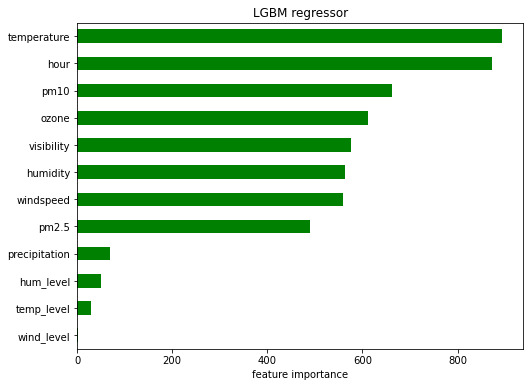

In [123]:
plt.figure(figsize = (8, 6))
Series_feat_imp_LGB.plot.barh(color = 'g')
plt.xlabel('feature importance')
plt.title('LGBM regressor')

plt.show()

### 2. Random Forest Regressor 

In [124]:
feature_importance_RF = model_RF_new.feature_importances_
Series_feat_imp_RF = pd.Series(feature_importance_RF, index = X_train.columns)
Series_feat_imp_RF = Series_feat_imp_RF.sort_values(ascending = True)

In [125]:
feature_importance_RF

array([0.58460586, 0.18060718, 0.02492935, 0.03096195, 0.0377508 ,
       0.03489612, 0.03858463, 0.03804284, 0.02212409, 0.00230703,
       0.00166868, 0.00352145])

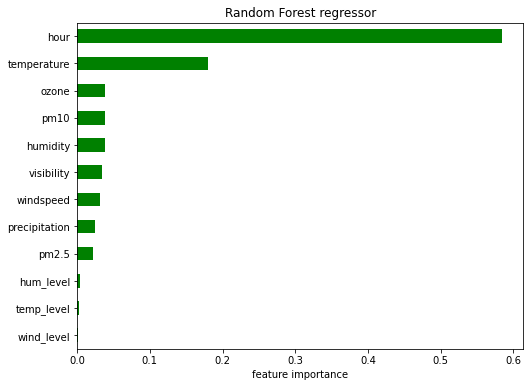

In [126]:
plt.figure(figsize = (8, 6))
Series_feat_imp_RF.plot.barh(color = 'g')
plt.xlabel('feature importance')
plt.title('Random Forest regressor')

plt.show()

### 3. Gradient Boosting Regressor 

In [127]:
feature_importance_GBR = model_GBR_new.feature_importances_
Series_feat_imp_GBR = pd.Series(feature_importance_GBR, index = X_train.columns)
Series_feat_imp_GBR = Series_feat_imp_GBR.sort_values(ascending = True)

In [128]:
feature_importance_GBR

array([0.62762227, 0.15874466, 0.02908443, 0.02095361, 0.04006427,
       0.02679511, 0.03139755, 0.04265206, 0.01860829, 0.00122232,
       0.00068467, 0.00217076])

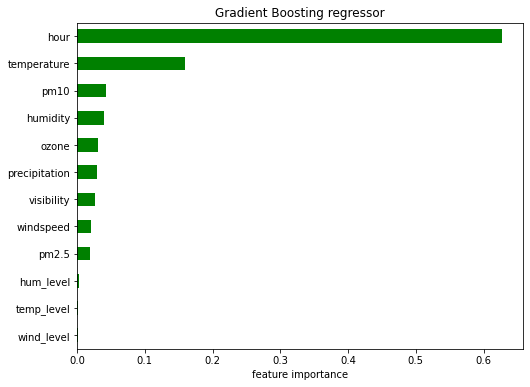

In [129]:
plt.figure(figsize = (8, 6))
Series_feat_imp_GBR.plot.barh(color = 'g')
plt.xlabel('feature importance')
plt.title('Gradient Boosting regressor')

plt.show()

### 4. K-Nearest Neighbor
* **KNeighborsRegressor 패키지는 feature_importances_ 속성이 없는 대신, 제일 효과적인 거리계산법을 확인할 수 있다.**
* **본 데이터는 Euclidean-distance 보다는 Manhattan-distance 가 더욱 성능 개선에 효과적이었다.**

In [130]:
model_KNN_new.effective_metric_

'manhattan'

# [p-value 및 VIF 확인] 

## 1) p-value 확인

In [131]:
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [132]:
# 아래의 features_plus 작업 시 pm2.5에 마침표가 있어 오류가 나므로 이를 pm2_5로 바꿔준다
data = data.rename(columns = {'pm2.5':'pm2_5'})

In [133]:
data.columns

Index(['hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'pm2_5', 'count', 'temp_level',
       'wind_level', 'hum_level'],
      dtype='object')

In [134]:
features_plus = 'hour + temperature + precipitation + windspeed + humidity + visibility + ozone + pm10 + pm2_5 + wind_level + temp_level + hum_level'

In [135]:
# dmatrices는 두 가지를 반환하는데, 첫번째는 target변수의 값, 두번째는 각 변수들의 값을 반환한다.
# 따라서 이를 y, x로 순서대로 할당한다.

y, X = dmatrices("count~" + features_plus, data = data, return_type = 'dataframe')

In [136]:
result = sm.OLS(y, X).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                  count   R-squared:                       0.610
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     173.9
Date:                Thu, 24 Jun 2021   Prob (F-statistic):          3.62e-284
Time:                        07:03:15   Log-Likelihood:                -7823.2
No. Observations:                1459   AIC:                         1.567e+04
Df Residuals:                    1445   BIC:                         1.575e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         -21.2979     18.141     

* **Notes[2]에서 다중공선성이 의심되는 것을 확인할 수 있다.**
* **p-value >= 0.5이면 다중공선성을 나타낼 수 있기 때문에 해당 컬럼을 feature에서 제외하며 성능을 재평가해야 한다.**
* **이 경우, wind_level, pm2_5, hum_level을 제거하고 모델의 성능을 평가해 보는 것이 필요하다.**

## 2) VIF 확인
* **Variance inflation factor: 분산 팽창 인수**
* **10이 넘으면 다중공선성이 있다고 판단, 5가 넘으면 주의**
* **예를 들어, 기존에 개별 독립변수와 종속변수 간의 상관관계에서 양이 나왔는데, 위의 표에서 음이 나왔다거나 한다면 다중공선성에 의해 회귀분석 결과가 왜곡되었다고 할 수 있다.**

In [137]:
vif_table = pd.DataFrame()
vif_table['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif_table['features'] = X.columns

In [138]:
vif_table.round(2)

,VIF,features
0,178.75,Intercept
1,2.13,wind_level[T.2]
2,6.13,wind_level[T.3]
3,1.45,hour
4,2.19,temperature
5,1.15,precipitation
6,5.31,windspeed
7,3.35,humidity
8,3.33,visibility
9,1.76,ozone


* **다중공선성이 10 이상인 feature는 존재하지 않는 것으로 확인되었다.**

# [p-value에 따른 feature 재설정] 
* **wind_level, pm2_5, hum_level을 제거**

In [139]:
features = ['hour', 'temperature', 'precipitation', 'windspeed', 'humidity',
       'visibility', 'ozone', 'pm10', 'temp_level']

In [140]:
label = 'count'

* **X_train, y_train 재정의**

In [141]:
X_train = data[features]
y_train = data[label]

In [142]:
print(X_train.shape)
print(y_train.shape)

(1459, 9)
(1459,)


* **train_X, val_X, train_y, val_y 도 변경된 feature에 맞춰 재정의**

In [143]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train,
                                                 test_size = 0.25,
                                                 random_state = 1618)

print(train_X.shape, val_X.shape, train_y.shape, val_y.shape)

(1094, 9) (365, 9) (1094,) (365,)


* **KNN을 위해 변경된 feature에 맞춰 재 정규화**

In [144]:
scaler.fit(train_X)

StandardScaler()

In [145]:
train_X_scale = scaler.transform(train_X)
val_X_scale = scaler.transform(val_X)

# [Fitting and Prediction] 

In [146]:
model_RF_new.fit(train_X, train_y)

pred_y_RF_new = model_RF_new.predict(val_X)
pred_y_RF_new[:5]

array([ 79.7056658 ,  42.14995844, 105.66027661, 122.1896189 ,
       199.88130125])

In [147]:
model_GBR_new.fit(train_X, train_y)

pred_y_GBR_new = model_GBR_new.predict(val_X)
pred_y_GBR_new[:5]

array([ 71.0241333 ,  35.80612002, 109.60381135, 134.43717675,
       222.08355628])

In [148]:
# lgbm의 빠른 속도를 위해 early_stopping_rounds 추가
evals = [(val_X, val_y)]

model_LGB_new.fit(train_X, train_y, early_stopping_rounds = 100, eval_set = evals, verbose = False)

pred_y_LGB_new = model_LGB_new.predict(val_X)
pred_y_LGB_new[:5]

array([ 75.30566649,  39.99835892,  86.63667923, 139.6583211 ,
       231.21019354])

In [149]:
# KNN은 정규화한 feature를 이용하여 fitting

model_KNN_new.fit(train_X_scale, train_y)

pred_y_KNN_new = model_KNN_new.predict(val_X_scale)
pred_y_KNN_new[:5]

array([ 86.46568516,  39.18888819,  98.12575438, 116.78197523,
       267.93475799])

# [개선된 모델의 성능 평가] 

### 1. RMSE : Root Mean Squared Error 

In [150]:
from sklearn.metrics import mean_squared_error

In [151]:
rmse_RF_new = np.sqrt(mean_squared_error(val_y, pred_y_RF_new))

rmse_GBR_new = np.sqrt(mean_squared_error(val_y, pred_y_GBR_new))

rmse_LGB_new = np.sqrt(mean_squared_error(val_y, pred_y_LGB_new))

rmse_KNN_new = np.sqrt(mean_squared_error(val_y, pred_y_KNN_new))

print("New RMSE of Random Forest Regressor = {0:.5f}".format(rmse_RF_new), "\n")
print("New RMSE of Gradient Boosting Regressor = {0:.5f}".format(rmse_GBR_new), '\n')
print("New RMSE of LGBM = {0:.5f}".format(rmse_LGB_new), '\n')
print("New RMSE of KNN = {0:.5f}".format(rmse_KNN_new))

New RMSE of Random Forest Regressor = 37.09706 

New RMSE of Gradient Boosting Regressor = 38.16540 

New RMSE of LGBM = 36.94241 

New RMSE of KNN = 45.30934


### 2. RMSLE: Root Mean Sqaured Log Error

In [152]:
print(pred_y_RF_new.min(), pred_y_GBR_new.min(), pred_y_LGB_new.min(), pred_y_KNN_new.min())

7.548355158730158 -0.055907704715077576 -1.1285517534780527 9.427398816074769


* **자전거 대여량은 negative value가 될 수 없으므로 해당 value는 다 0으로 처리해야 한다.**

In [153]:
pred_y_GBR_new[pred_y_GBR_new < 0] = 0
pred_y_LGB_new[pred_y_LGB_new < 0] = 0

In [154]:
from sklearn.metrics import mean_squared_log_error

In [155]:
rmsle_RF_new = np.sqrt(mean_squared_log_error(val_y, pred_y_RF_new))

rmsle_GBR_new = np.sqrt(mean_squared_log_error(val_y, pred_y_GBR_new))

rmsle_LGB_new = np.sqrt(mean_squared_log_error(val_y, pred_y_LGB_new))

rmsle_KNN_new = np.sqrt(mean_squared_log_error(val_y, pred_y_KNN_new))

print("New RMSLE of Random Forest Regressor = {0:.5f}".format(rmsle_RF_new), "\n")
print("New RMSLE of Gradient Boosting Regressor = {0:.5f}".format(rmsle_GBR_new), '\n')
print("New RMSLE of LGBM = {0:.5f}".format(rmsle_LGB_new), '\n')
print("New RMSLE of KNN = {0:.5f}".format(rmsle_KNN_new))

New RMSLE of Random Forest Regressor = 0.49052 

New RMSLE of Gradient Boosting Regressor = 0.49336 

New RMSLE of LGBM = 0.47357 

New RMSLE of KNN = 0.59541


### 3.  R-squared

In [156]:
from sklearn.metrics import r2_score

In [157]:
R2_RF_new = r2_score(val_y, pred_y_RF_new)
R2_GBR_new = r2_score(val_y, pred_y_GBR_new)
R2_LGBM_new = r2_score(val_y, pred_y_LGB_new)
R2_KNN_new = r2_score(val_y, pred_y_KNN_new)

print("New R2 of RF = {0:.5f}".format(R2_RF_new), '\n')
print("New R2 of GBR = {0:.5f}".format(R2_GBR_new), '\n')
print("New R2 of LGBM = {0:.5f}".format(R2_LGBM_new), '\n')
print("New R2 of KNN = {0:.5f}".format(R2_KNN_new))

New R2 of RF = 0.78178 

New R2 of GBR = 0.76903 

New R2 of LGBM = 0.78360 

New R2 of KNN = 0.67447


# [최종 결과] 

In [158]:
pd.DataFrame({'모델': ['RandomForest', 'GradientBoosting', 'LightGBM', 'K-NearestNeighbor'],
              'RMSE(개선 전)': [rmse_RF, rmse_GBR, rmse_LGB, rmse_KNN],
              'RMSE(개선 후)' : [rmse_RF_new, rmse_GBR_new, rmse_LGB_new, rmse_KNN_new],
              'RMSLE(개선 전)' : [rmsle_RF, rmsle_GBR, rmsle_LGB, rmsle_KNN],
              'RMSLE(개선 후)' : [rmsle_RF_new, rmsle_GBR_new, rmsle_LGB_new, rmsle_KNN_new],
              'R2(개선 전)' : [R2_RF, R2_GBR, R2_LGBM, R2_KNN],
              'R2(개선 후)' : [R2_RF_new, R2_GBR_new, R2_LGBM_new, R2_KNN_new]})

,모델,RMSE(개선 전),RMSE(개선 후),RMSLE(개선 전),RMSLE(개선 후),R2(개선 전),R2(개선 후)
0,RandomForest,37.532039,37.097059,0.485433,0.490517,0.776636,0.781783
1,GradientBoosting,38.223265,38.165401,0.542418,0.493360,0.768399,0.769034
2,LightGBM,37.780774,36.942409,0.542436,0.473568,0.773755,0.783602
3,K-NearestNeighbor,65.290457,45.309340,0.836070,0.595413,0.324060,0.674475


In [159]:
submission = pd.read_csv('submission.csv')
submission.head()

,id,count
0,0,NaN
1,1,NaN
2,2,NaN
3,4,NaN
4,5,NaN


In [ ]:
submission['count'] = y_pred_200
submission.head()